Libraries and dataset

In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
import scipy.stats as stats
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, HuberRegressor, QuantileRegressor,PoissonRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

url = "https://raw.githubusercontent.com/paobranco/Imbalanced-Regression-DataSets/refs/heads/master/CSV_data/bank8FM.csv"

df = pd.read_csv(url)


## EDA


Shape: (4499, 9)
Columns: ['rej', 'a1cx', 'a1cy', 'b2x', 'b2y', 'a2pop', 'a3pop', 'temp', 'mxql']

Numeric describe:
         count      mean       std       min       25%       50%       75%  \
rej    4499.0  0.160904  0.151200  0.000000  0.032970  0.116767  0.248855   
a1cx   4499.0 -0.000377  0.293142 -0.499817 -0.255907 -0.000819  0.258842   
a1cy   4499.0 -0.013835  0.290376 -0.499969 -0.266992 -0.021239  0.236565   
b2x    4499.0 -0.000801  0.290154 -0.499965 -0.253953  0.009557  0.252269   
b2y    4499.0 -0.000600  0.284801 -0.499607 -0.249391 -0.000052  0.245789   
a2pop  4499.0  3.050142  3.072723  0.000049  0.899118  2.126109  4.187527   
a3pop  4499.0  3.081057  3.127659  0.001597  0.926472  2.135035  4.209344   
temp   4499.0  0.603991  0.202017  0.038388  0.457112  0.625740  0.765494   
mxql   4499.0  6.494777  1.129127  5.000000  5.000000  7.000000  8.000000   

             max  
rej     0.802263  
a1cx    0.499919  
a1cy    0.499977  
b2x     0.499948  
b2y     0.498851

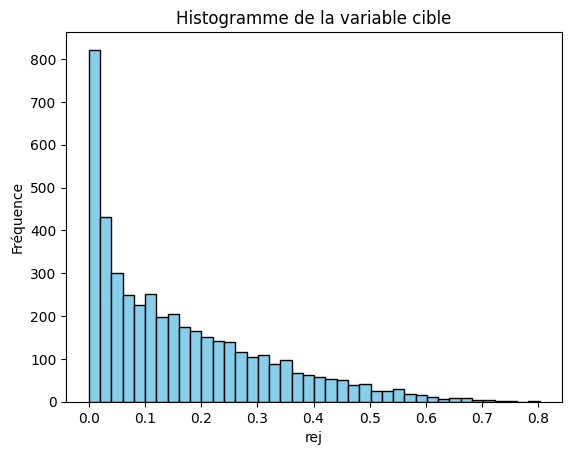

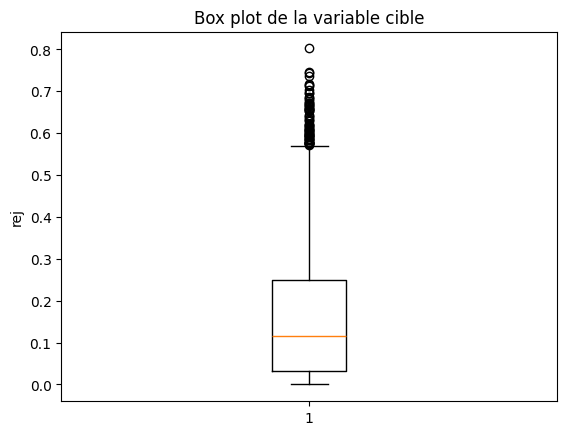

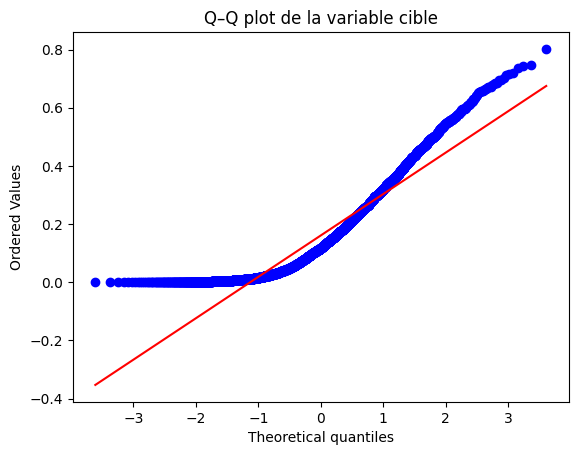

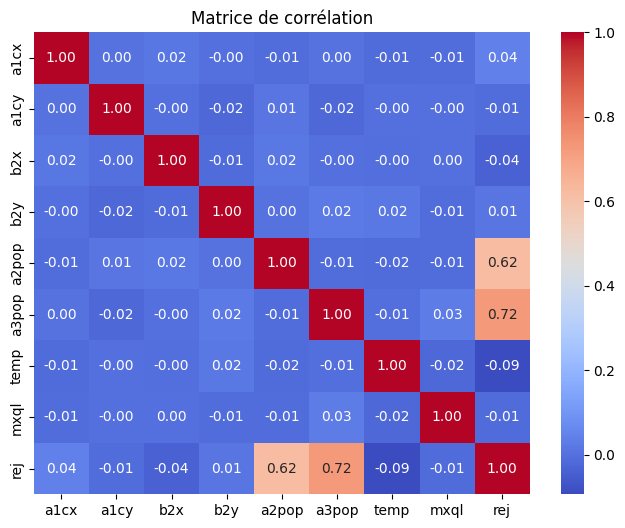

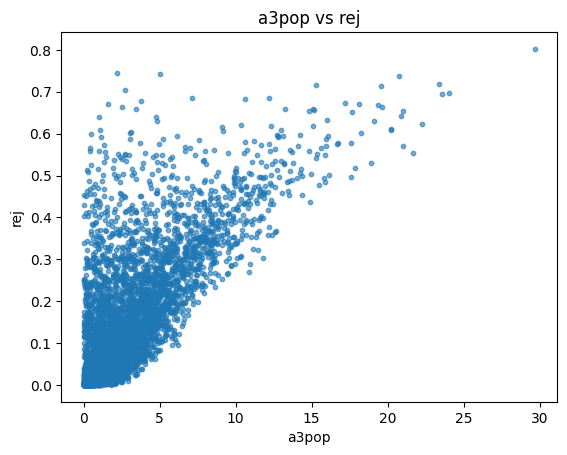

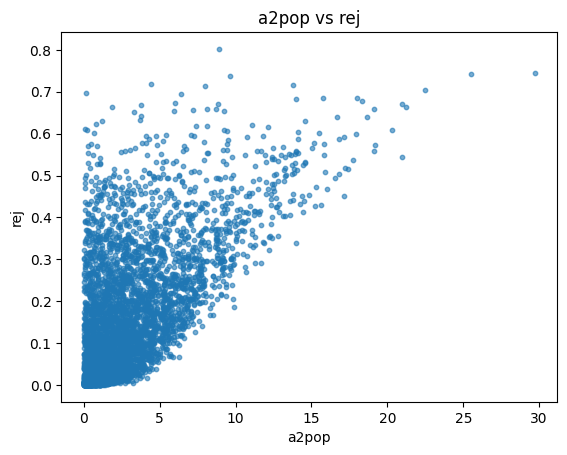

In [17]:
# Données
X = df.drop(columns=['rej'])
y = df['rej']

print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("\nNumeric describe:\n", df.describe().T)


# --- Histogramme de la cible ---
plt.hist(y, bins=40, color='skyblue', edgecolor='black')
plt.title("Histogramme de la variable cible")
plt.xlabel("rej")
plt.ylabel("Fréquence")
plt.show()

# --- Box plot ---
plt.boxplot(y, vert=True)
plt.title("Box plot de la variable cible")
plt.ylabel("rej")
plt.show()

# --- Q-Q plot (vérifie la normalité) ---
stats.probplot(y, dist="norm", plot=plt)
plt.title("Q–Q plot de la variable cible")
plt.show()

# --- Heatmap de corrélation sur X + y ---
data = X.copy()
data["rej"] = y
corr = data.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

# --- Scatter plots avec les variables les plus corrélées ---
top2 = corr['rej'].drop('rej').abs().nlargest(2).index
for feat in top2:
    plt.scatter(X[feat], y, s=10, alpha=0.6)
    plt.title(f"{feat} vs rej")
    plt.xlabel(feat)
    plt.ylabel("rej")
    plt.show()

Right-skewed distribution: the target variable rej is concentrated around 0 with a long tail on the right.

Presence of outliers: several extreme values beyond 0.5 confirm asymmetry and potential influence points.

Central tendency: mean = 0.16 > median = 0.12 → distribution is non-normal.

Correlation structure: strong correlation with

a3pop (r = 0.72)

a2pop (r = 0.62)
indicating these two variables are the main predictors of rej.

## Initial Global Model and residual diagnostics

                            OLS Regression Results                            
Dep. Variable:                    rej   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     7664.
Date:                Mon, 19 Jan 2026   Prob (F-statistic):               0.00
Time:                        23:41:47   Log-Likelihood:                 8155.6
No. Observations:                4499   AIC:                        -1.629e+04
Df Residuals:                    4490   BIC:                        -1.624e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0212      0.004      5.320      0.0

<Figure size 1000x400 with 0 Axes>

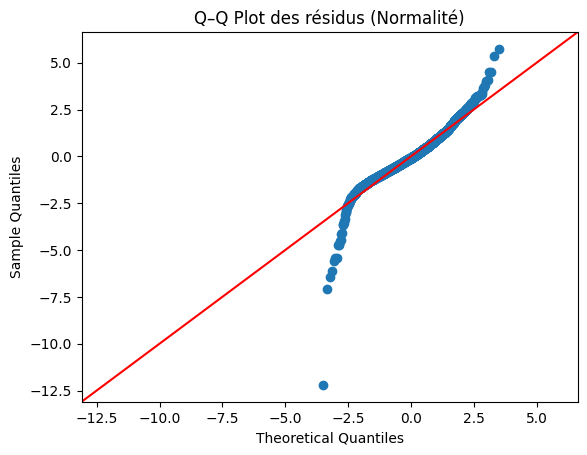

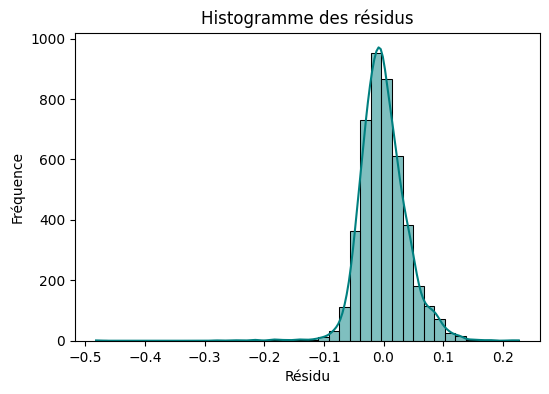

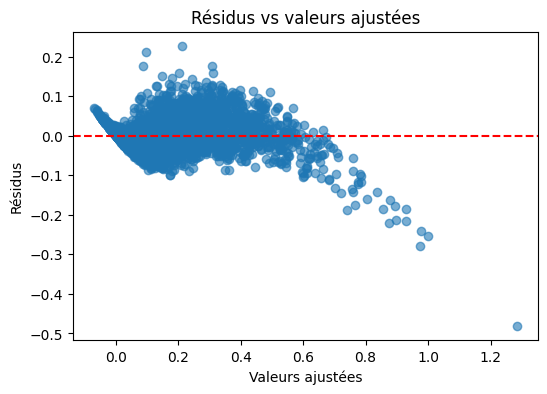

In [18]:
# Regression linéaire
X_with_intercept = sm.add_constant(X)
model = sm.OLS(y, X_with_intercept).fit()
print(model.summary())
# Résidus
residuals = model.resid
y_pred = model.fittedvalues

# QQplot des erreurs
plt.figure(figsize=(10, 4))
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q–Q Plot des résidus (Normalité)")
plt.show()

#  Histogramme + densité des résidus ---
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=40, kde=True, color='teal')
plt.title("Histogramme des résidus")
plt.xlabel("Résidu")
plt.ylabel("Fréquence")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Résidus vs valeurs ajustées")
plt.xlabel("Valeurs ajustées")
plt.ylabel("Résidus")
plt.show()



In [19]:
# --- 8) Test de normalité (Shapiro-Wilk) ---
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk test: Stat={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.4f}")

if shapiro_test.pvalue > 0.05:
    print("Les résidus suivent une distribution normale (p > 0.05)")
else:
    print(" Résidus non normaux (p ≤ 0.05)")

# --- 9) Vérification de l’homoscédasticité (Breusch-Pagan) ---

bp_test = het_breuschpagan(residuals, X_with_intercept)
print(f"Breusch-Pagan test: Stat={bp_test[0]:.4f}, p-value={bp_test[1]:.4f}")
labels = ['LM Stat', 'LM p-val', 'F Stat', 'F p-val']
print(dict(zip(labels, bp_test)))

Shapiro-Wilk test: Stat=0.9454, p-value=0.0000
 Résidus non normaux (p ≤ 0.05)
Breusch-Pagan test: Stat=638.1102, p-value=0.0000
{'LM Stat': np.float64(638.1101961016732), 'LM p-val': np.float64(1.491651043920699e-132), 'F Stat': np.float64(92.76083124684159), 'F p-val': np.float64(4.011751618472024e-143)}


R square = 93,2%, the variance well explain,

correlated variables are significante with high coefficient :  p < 0.001

Residual normality: Shapiro–Wilk = 0.9454, p < 0.001 → residuals are not normally distributed.

Homoscedasticity: Breusch–Pagan LM = 638.11, p ≈ 0.0 → heteroscedasticity detected.

Residual pattern: Histogram centered near 0 but with fat tails (kurtosis ≈ 11.0) and slight skewness (–0.28); Q–Q plot shows heavy tails and deviations at both extremes.

Residual vs fitted: Funnel-shaped dispersion indicates increasing variance with fitted values → violation of constant variance assumption.

Despite strong fit, OLS assumptions (normality & homoscedasticity) are violated; outliers and tail effects dominate → calls for robust or segmented modeling